In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset
carslm = pd.read_csv('./carslm1.csv')
carslm.head()

,id,speed,dist
0,1,4,2
1,2,4,10
2,3,7,4
3,4,7,22
4,5,8,16


In [3]:
#Drop ID
dfnew =carslm.drop('id',axis=1)
dfnew.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [4]:
#Show Key Statistics
dfnew.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


In [5]:
# Overview of Dataset Characteristics
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
speed    50 non-null int64
dist     50 non-null int64
dtypes: int64(2)
memory usage: 880.0 bytes


In [6]:
#First pip install pandas-profiling

# importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Profile Report
carslm2 = pp.ProfileReport(dfnew)
carslm2.to_file('carslm.html')
display(IFrame('carslm.html', width=900, height=350))

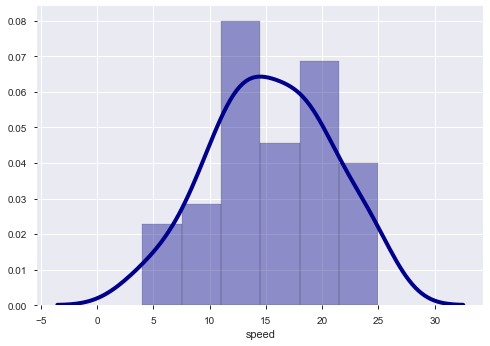

In [7]:
# Density Plot and Histogram of Speed
sns.distplot(dfnew['speed'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

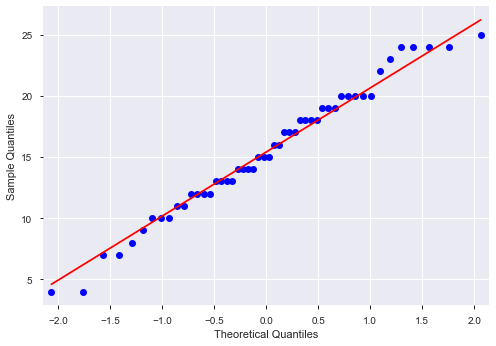

In [8]:
from statsmodels.graphics.gofplots import qqplot
import pylab
# q-q plot
qqplot(dfnew['speed'],line='s')
pylab.show()

In [9]:
#Normality test - Shapiro-Wilk Test

#    p <= alpha(0.05): reject H0, not normal.
#   p > alpha(0.05): fail to reject H0, normal.

from scipy.stats import shapiro
stat, p = shapiro(dfnew['speed'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.978, p=0.458
Sample looks Gaussian (fail to reject H0)


In [10]:
#Script for Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Define x and y variable
x=dfnew['speed'].values
y=dfnew['dist'].values

#Load Library for Training Dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Converting variables to 2D
x_train2 = x_train.reshape(-1,1)
x_test2 = x_test.reshape(-1,1)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train3 = sc.fit_transform(x_train2)
x_test3 = sc.fit_transform(x_test2)

In [11]:
#Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train3, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_mean_squared_error',
                                                            cv=10,
                                                            n_jobs=1,random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([0,25])
    plt.show()

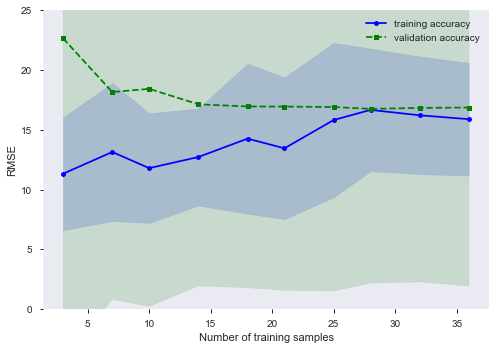

In [12]:
#Plot Learning Curve
lm=LinearRegression()
plot_learning_curves(lm)

In [13]:
#Create Orginal Model
for name,method in [('Linear regression', LinearRegression())]: 
    method.fit(x_train3,y_train)
    predict = method.predict(x_test3)

print('\nOriginal Model')
print('\nMethod: {}'.format(name)) 

#Coefficents
print('\nIntercept: {:0.2f}'.format(float(method.intercept_)))
print('Coefficient: {:0.2f}'.format((float(method.coef_))))
    
#MAE,MSE and RMSE
print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test,predict)))
print('Mean Absolute Error: {:0.2f}'.format(metrics.mean_absolute_error(y_test, predict)))  
print('Mean Squared Error: {:0.2f}'.format(metrics.mean_squared_error(y_test, predict)))  
print('Root Mean Squared Error: {:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, predict)))) 


Original Model

Method: Linear regression

Intercept: 41.20
Coefficient: 19.94

R2: 0.67
Mean Absolute Error: 10.95
Mean Squared Error: 190.67
Root Mean Squared Error: 13.81


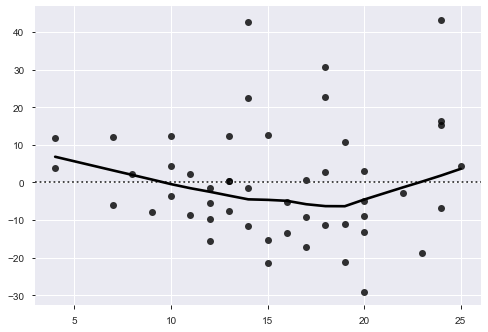

In [14]:
# Plot the residuals after fitting a linear model
sns.residplot(x,y, lowess=True, color="black")

Model Evaluation - Accuracy Score
Linear Regression 15.58




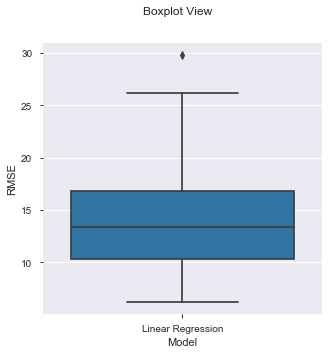

In [15]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Linear Regression',lm))

#Model Evaluation
results =[]
names=[]
scoring ='neg_mean_squared_error'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x.reshape(-1,1),y.reshape(-1,1),cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [16]:
#Gridsearch - Optimized Model

from sklearn.model_selection import GridSearchCV

#Linear Model
lm2=LinearRegression()
cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
param_grid = {'fit_intercept':[True,False],'normalize':[True,False], 'copy_X':[True, False]}
lm2_model = GridSearchCV(lm2, param_grid, cv=cv2, verbose=0,scoring = 'neg_mean_squared_error',n_jobs=-1)

grids = [lm2_model] 
grid_dict = {0:'LinearReg'}

#Model Creation
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Optimized Model') 

#Fit the grid search objects 
for idx, optmodel in enumerate(grids): 
     print('\nEstimator: {}'.format(grid_dict[idx]))
     #Fit grid search
     optmodel.fit(x_train3, y_train) 
     #Best params 
     print('\nBest params: {}'.format(optmodel.best_params_))
     # Predict on test data with best params 
     y_pred3 = optmodel.predict(x_test3) 
     # Intercept and Coefficients   
     print('\nIntercept: {:0.2f}'.format(float(optmodel.best_estimator_.intercept_)))
     print('\nCoefficient: {:0.2f}'.format(float(optmodel.best_estimator_.coef_)))   
     # Test data accuracy of model with best params  
     print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test, y_pred3)))
     print('Mean Absolute Error: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_pred3)))  
     print('Mean Squared Error: {:0.2f}'.format(metrics.mean_squared_error(y_test, y_pred3)))  
     print('Root Mean Squared Error: {:.02f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred3))))  

Optimized Model

Estimator: LinearReg

Best params: {'copy_X': True, 'fit_intercept': True, 'normalize': False}

Intercept: 41.20

Coefficient: 19.94

R2: 0.67
Mean Absolute Error: 10.95
Mean Squared Error: 190.67
Root Mean Squared Error: 13.81


In [17]:
# If Not normal you can use Yeo-Johnson Transformation

#Load Dataset
dataset_trf=carslm.drop('id',axis=1)

#Define x and y variable
x_trf=dataset_trf['speed'].values
y_trf=dataset_trf['dist'].values

#Load Library for Training Dataset
from sklearn.model_selection import train_test_split
x_train_trf,x_test_trf,y_train_trf,y_test_trf=train_test_split(x_trf,y_trf,test_size=0.2,random_state=100)

#Converting variables to 2D
x_train_trf = x_train_trf.reshape(-1,1)
x_test_trf = x_test_trf.reshape(-1,1)
y_train_trf = y_train_trf.reshape(-1,1)
y_test_trf = y_test_trf.reshape(-1,1)

#Scale Independent Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_trf = sc.fit_transform(x_train_trf)
x_test_trf = sc.fit_transform(x_test_trf)

#Tranform Dependent Variable
from sklearn.preprocessing import power_transform
transf_ytrain=power_transform(y_train_trf,method='yeo-johnson')
transf_ytest=power_transform(y_test_trf,method='yeo-johnson')

In [18]:
#Create Tranformed Model
for name,method2 in [('Linear regression', LinearRegression())]: 
    method2.fit(x_train_trf,transf_ytrain)
    predict = method2.predict(x_test_trf)

print('\nTransformed Model - Yeo-Johnson')
print('\nMethod: {}'.format(name)) 

#Coefficents
print('\nIntercept: {:0.2f}'.format(float(method2.intercept_)))
print('Coefficient: {:0.2f}'.format((float(method2.coef_))))
    
#R2 and RMSE
print('\nR2: {:0.2f}'.format(metrics.r2_score(transf_ytest,predict)))
print('Root Mean Squared Error: {:0.2f}'.format(np.exp(np.sqrt(metrics.mean_squared_error(transf_ytest, predict))))) 


Transformed Model - Yeo-Johnson

Method: Linear regression

Intercept: 0.00
Coefficient: 0.82

R2: 0.81
Root Mean Squared Error: 1.54


In [19]:
# Predictions 
raw_data={'speedNew':[4]}
dfnew=pd.DataFrame(raw_data, columns = ['speedNew'])
dfnewdataset = pd.DataFrame(raw_data, columns = ['speedNew']).values
print('Prediction Distance - Original: {:0.2f}'.format(float(method.predict(dfnewdataset))))
print('Prediction Distance - Optimized: {:0.2f}'.format(float(optmodel.predict(dfnewdataset))))
print('Prediction Distance - Transformed Model: {:0.2f}'.format((float(method2.predict(dfnewdataset)*10))))

Prediction Distance - Original: 120.96
Prediction Distance - Optimized: 120.96
Prediction Distance - Transformed Model: 32.95
